## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
* Modularized the previous code

---
# Camera Calibration

## Step1: I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

### Find the Chessboard Corners

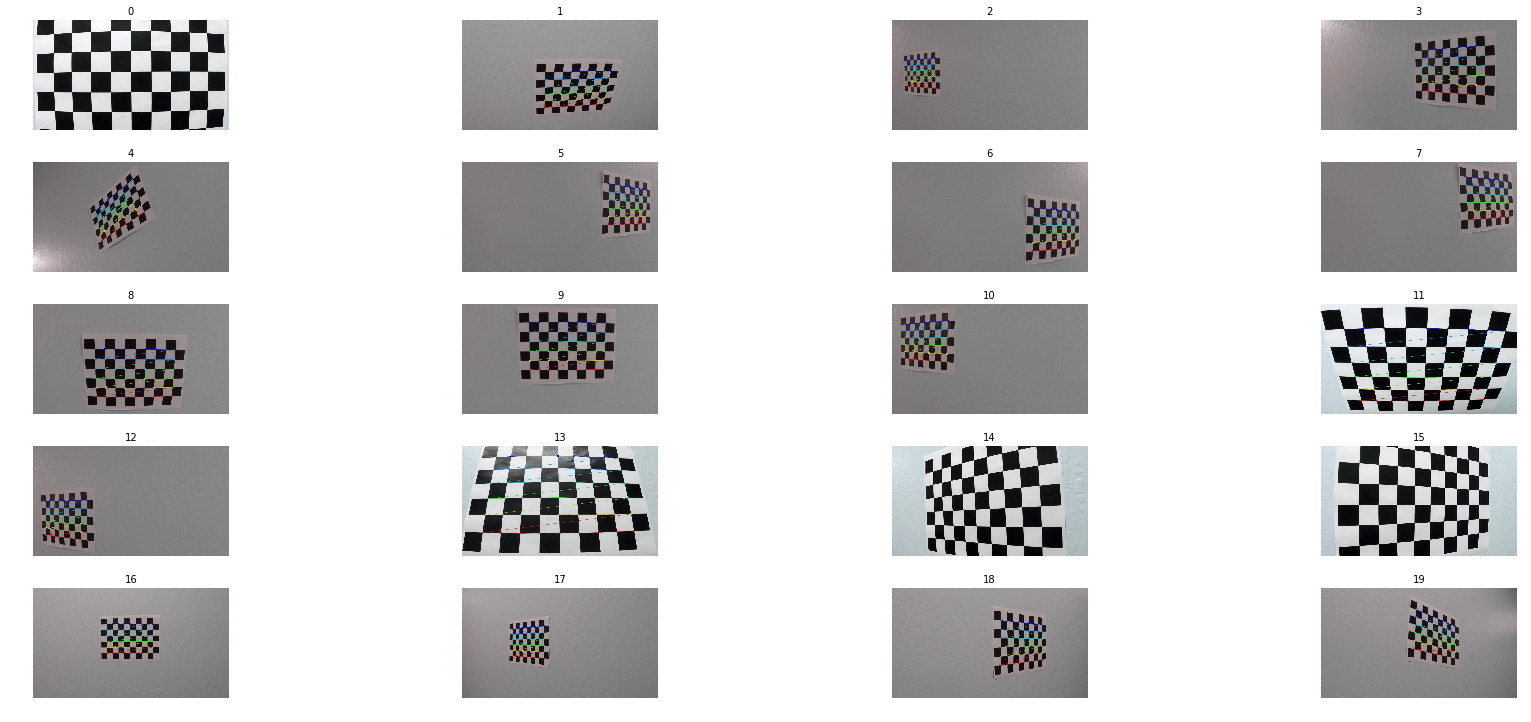

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Plot the result
fig, axs = plt.subplots(5, 4, figsize=(24, 10))  #axs[20]
axs = axs.flatten()

# fig.subplots_adjust(left=0.2, bottom=0.2, right=0.8, top=0.8, hspace=0.2, wspace=0.1)
fig.tight_layout()
# Step through the list and search for chessboard corners

serial_number = 0
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

    axs[i].axis("off")
    axs[i].imshow(img)
    axs[i].set_title(str(i), fontsize=10)

### Compute the camera calibration

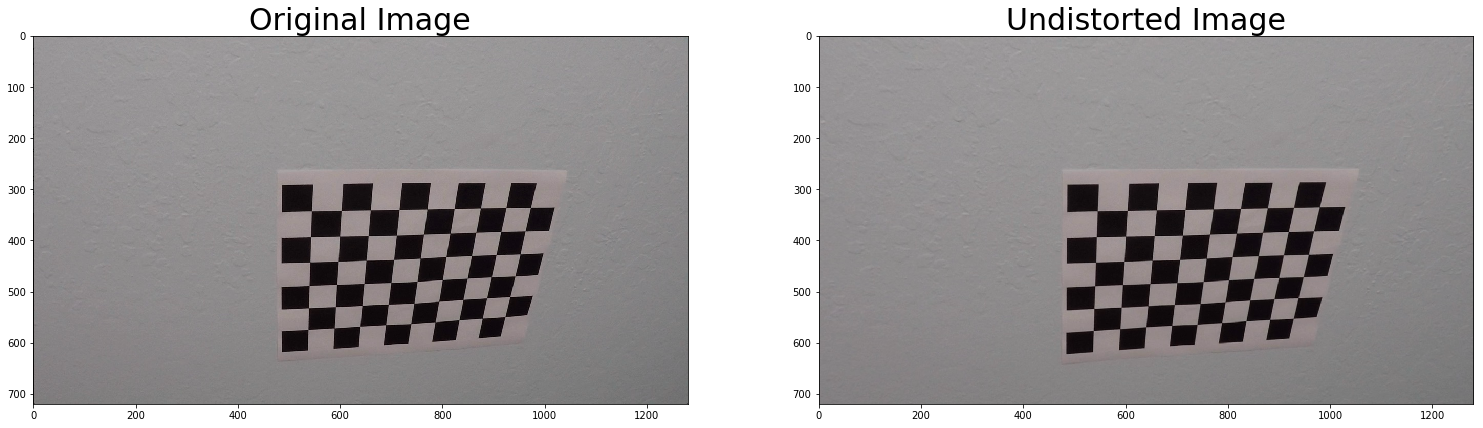

In [4]:
import pickle

# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration10.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./camera_cal/test_undist_10.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
dist_pickle["ret"] = ret
dist_pickle["rvecs"] = rvecs
dist_pickle["tvecs"] = tvecs
pickle.dump( dist_pickle, open( "./camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
fig, axs = plt.subplots(1, 2, figsize=(20,10))
axs[0].imshow(img)
axs[0].set_title('Original Image', fontsize=30)
axs[1].imshow(dst)
axs[1].set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Step2: I'll apply a distortion correction to raw images.

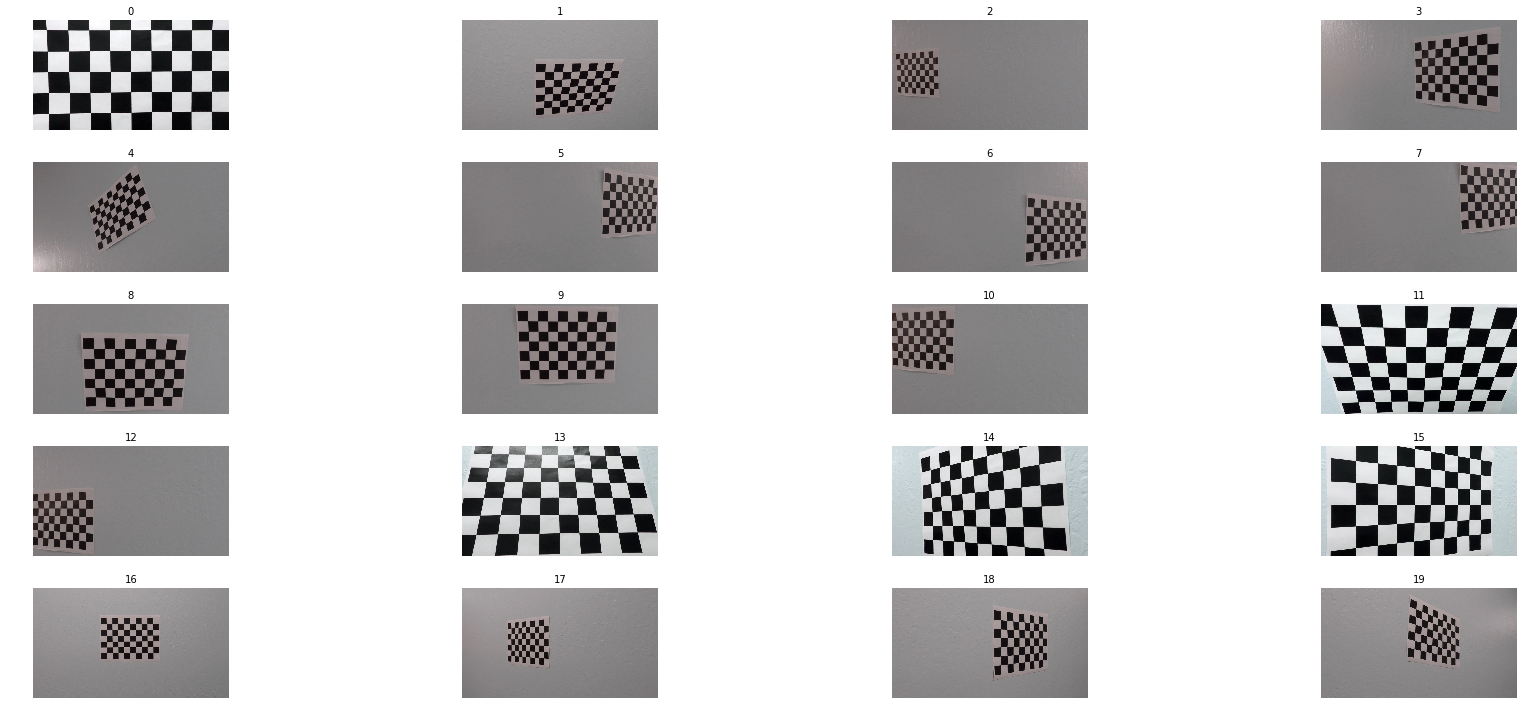

In [5]:
pkl_file = open( "./camera_cal/wide_dist_pickle.p", "rb" )
dist_pickle = pickle.load( pkl_file )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
# print('mtx=', mtx)
# print('dis=',dist)
# dst = cv2.undistort(img, mtx, dist, None, mtx)
# cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Plot the result
fig, axs = plt.subplots(5, 4, figsize=(24, 10))  #axs[20]
axs = axs.flatten()

# fig.subplots_adjust(left=0.2, bottom=0.2, right=0.8, top=0.8, hspace=0.2, wspace=0.1)
fig.tight_layout()
# Step through the list and search for chessboard corners

for i, fname in enumerate(images):
    img = cv2.imread(fname)
    
    dst = cv2.undistort(img, mtx, dist, None, mtx)
#     cv2.imwrite('calibration_wide/test_undist.jpg',dst)
    
    axs[i].axis("off")
    axs[i].imshow(dst)
    axs[i].set_title(str(i), fontsize=10)

# Pipeline(test images)

### Processing test images

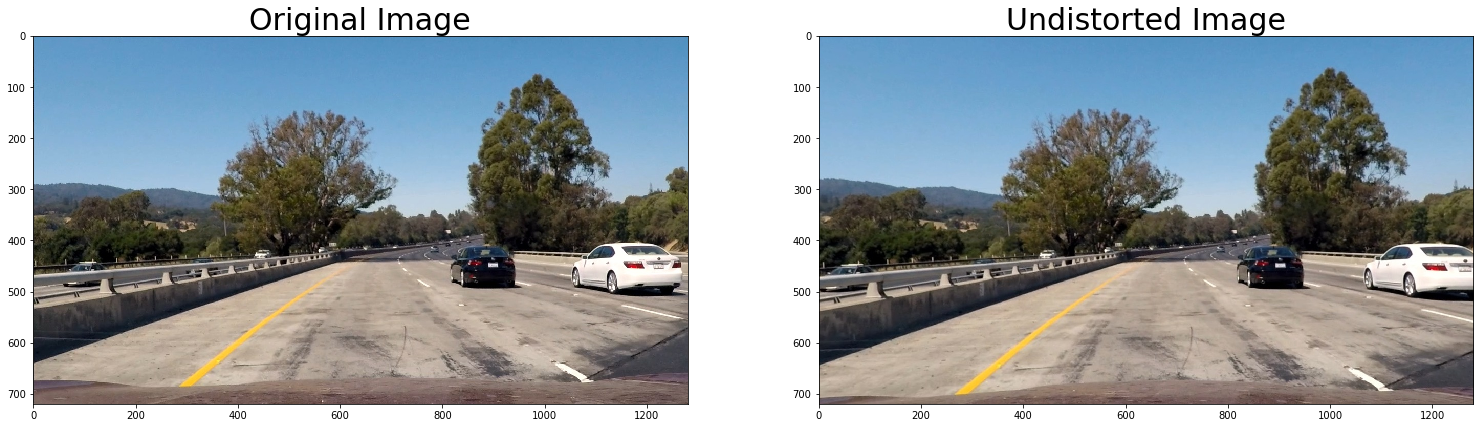

In [7]:
import os
images_name = os.listdir('./test_images')
# print(images_name)
for i, fname in enumerate(images_name):
    img = cv2.imread('./test_images/' + fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('./output_images/output_images_undistort/undistort_' + fname, dst)  #distortion correction of the picture, then save

img = cv2.imread('./test_images/test1.jpg')
undis_img = cv2.imread('./output_images/output_images_undistort/undistort_test1.jpg')
# Visualize undistortion of test images
fig, axs = plt.subplots(1, 2, figsize=(20,10))
axs[0].imshow(img[:,:,::-1])
axs[0].set_title('Original Image', fontsize=30)
axs[1].imshow(undis_img[:,:,::-1])
axs[1].set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Step3: I'll use color transforms, gradients, etc., to create a thresholded binary image.

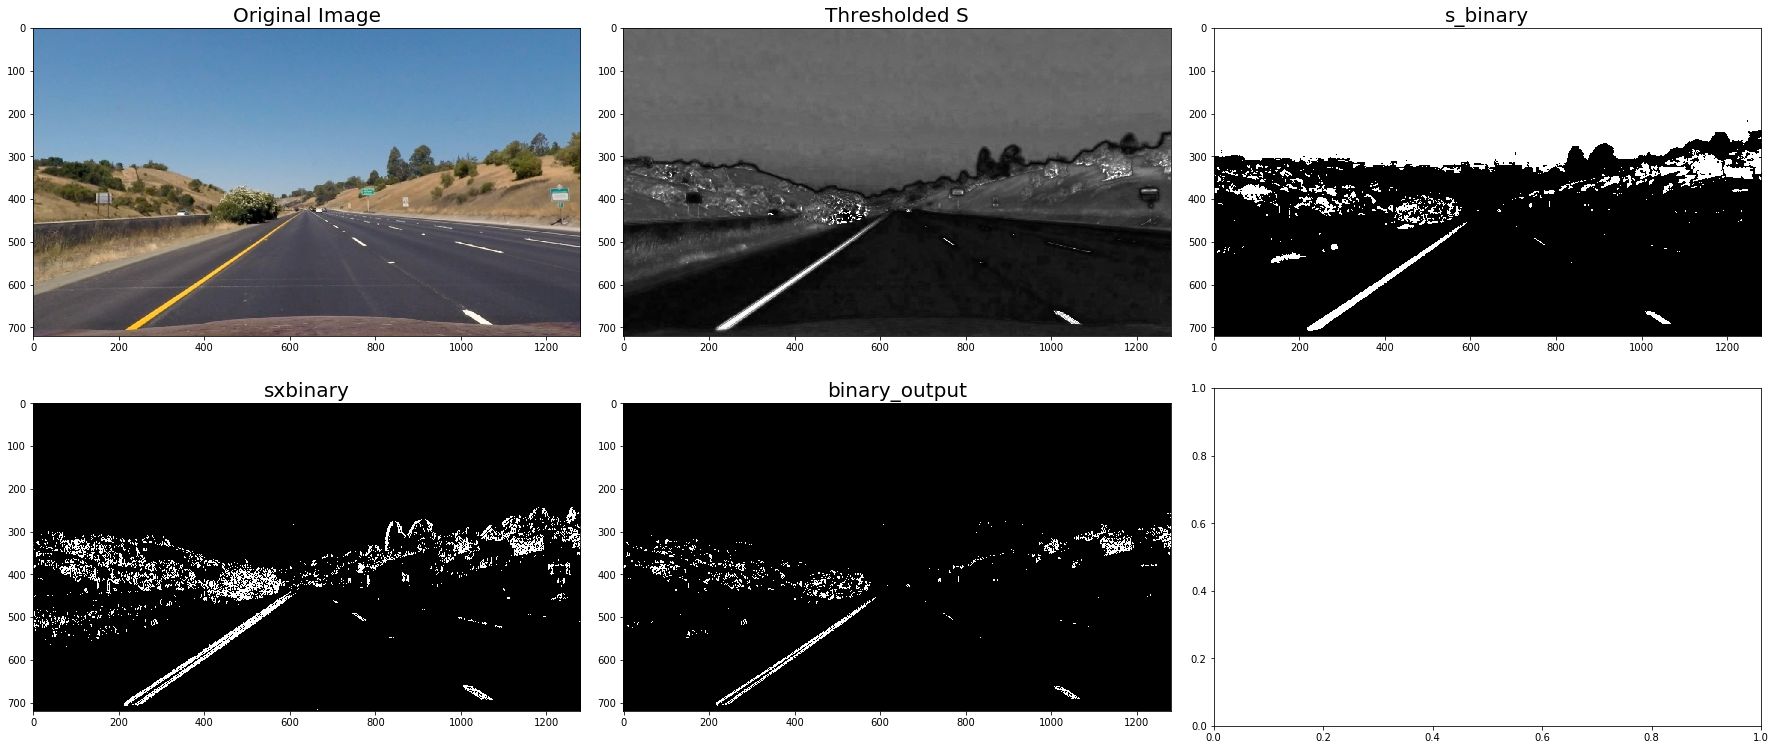

In [8]:
# Read the undistort_straight_lines1.jpg
img = cv2.imread('./output_images/output_images_undistort/undistort_straight_lines1.jpg') 

# Define a function that thresholds the S-channel of HLS
def binary_select(image, s_thresh=(170, 255), sx_thresh=(20, 100)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS) #Convert to HLS color space
    s_channel = hls[:,:,2] #Apply a threshold to the S channel
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 255

    
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 255
    
    #the threshold result of combine s_binary and sxbinary
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_binary >= 255) & (sxbinary >= 255)] = 255
    
    return s_channel, s_binary, sxbinary, binary_output 
    
s_channel, s_binary, sxbinary, binary_output = binary_select(img, s_thresh=(90, 255), sx_thresh=(10, 150))

# Plot the result
fig, axs = plt.subplots(2, 3, figsize=(24, 9))
fig.tight_layout()
axs = axs.flatten()
axs[0].imshow(img[:,:,::-1])
axs[0].set_title('Original Image', fontsize=20)
axs[1].imshow(s_channel, cmap='gray')
axs[1].set_title('Thresholded S', fontsize=20)
axs[2].imshow(s_binary, cmap='gray')
axs[2].set_title('s_binary', fontsize=20)
axs[3].imshow(sxbinary, cmap='gray')
axs[3].set_title('sxbinary', fontsize=20)
axs[4].imshow(binary_output, cmap='gray')
axs[4].set_title('binary_output', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=1.1, bottom=0.)

import os
images_name = os.listdir('./output_images/output_images_undistort')
# print(images_name)
for i, fname in enumerate(images_name):
    if fname.split('.')[-1] == 'jpg':
        img = cv2.imread('./output_images/output_images_undistort/' + fname)
        s_channel, s_binary, sxbinary, binary_output = binary_select(img, s_thresh=(90, 255), sx_thresh=(10, 150))
        cv2.imwrite('./output_images/output_images_binary_undistort/binary_' + fname, binary_output)  #create a thresholded binary image, then save?

## Step4: I'll apply a perspective transform to rectify binary image ("birds-eye view").

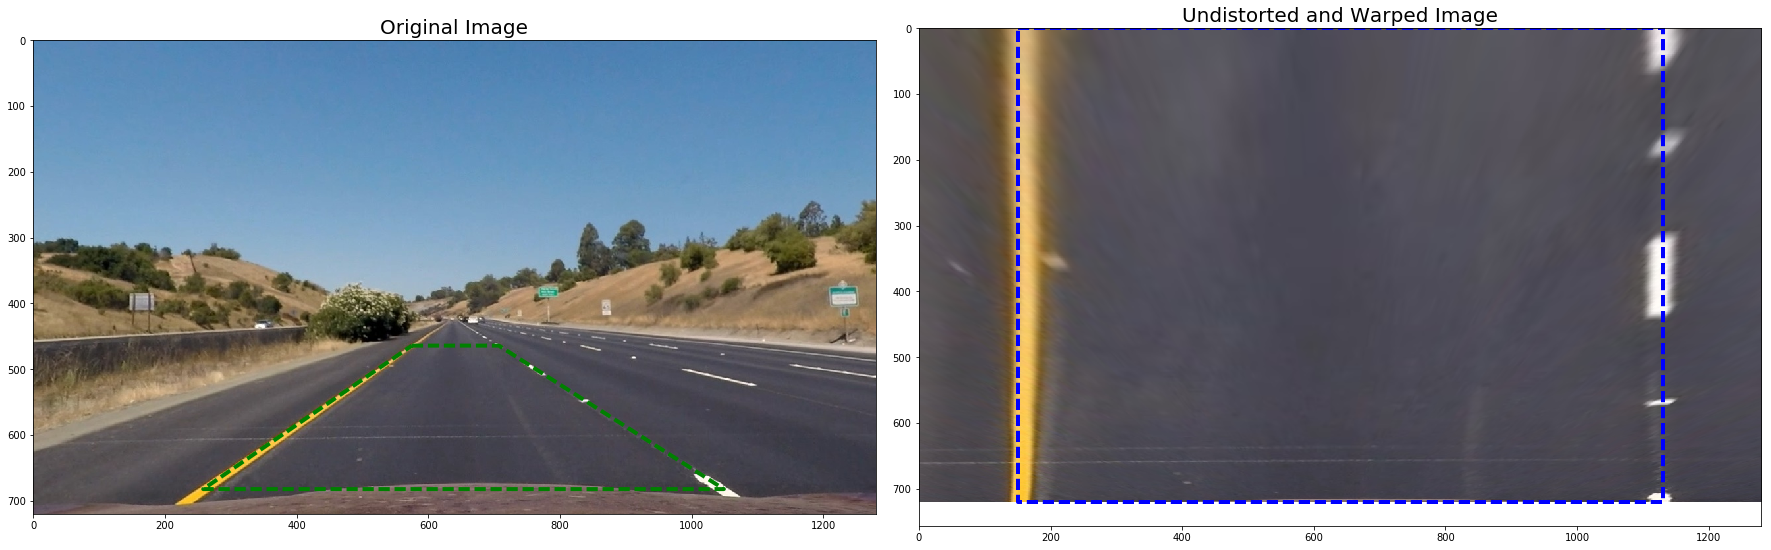

In [11]:
# Read in the saved camera matrix and distortion coefficients
pkl_file = open("./camera_cal/wide_dist_pickle.p", "rb")
dist_pickle = pickle.load(pkl_file)
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# the function of "birds-eye view"
def birds_eye_warp(img, src, dst): #src: 4 source points / dst: 4 destination points
    h,w = img.shape[:2]
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv


# Read in an image
img = cv2.imread('./output_images/output_images_undistort/undistort_straight_lines1.jpg') 


h,w = img.shape[:2]

# define source and destination points for transform
src = np.float32([[575,464], [707,464], 
                  [1049,682],[258,682]])

dst = np.float32([[150,0],[w-150,0],
                  [w-150,h],[150,h]])

# #test which are the best points in src and dst

x_src = []
y_src = []
x_dst = []
y_dst = []
x_vertices_quad = []
y_vertices_quad = []

for i in range(4):
    x_src.append(src[i][0])
    y_src.append(src[i][1])
x_src.append(src[0][0])
y_src.append(src[0][1])

for i in range(4):
    x_dst.append(dst[i][0])
    y_dst.append(dst[i][1])
x_dst.append(dst[0][0])
y_dst.append(dst[0][1])


top_down, perspective_M, perspective_Minv = birds_eye_warp(img, src, dst)
fig, axs = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()
axs = axs.flatten()
axs[0].imshow(img[:,:,::-1])
axs[0].set_title('Original Image', fontsize=20)
axs[1].imshow(top_down[:,:,::-1])
axs[1].set_title('Undistorted and Warped Image', fontsize=20)
axs[1].plot(x_dst, y_dst, 'b--', lw=4)
axs[0].plot(x_src, y_src, 'g--', lw=4)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)